# Импортирование библиотек

In [2]:
import time
import cv2
from datetime import datetime
from tqdm import tqdm
from PIL import ImageOps, ImageFilter
import PIL
import os
import sys
import random as rn
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, \
                                    ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, \
                                    Activation, Lambda, BatchNormalization,SeparableConv2D,\
                                    GlobalAveragePooling2D, LSTM,InputLayer, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Основные настройки

In [4]:
path_train = 'B:/STARS_05/train/'
path_train_0 = 'B:/STARS_05/train/0/'
path_train_1 = 'B:/STARS_05/train/1/'

path_test = 'B:/STARS_05/test/'
path_test_0 = 'B:/STARS_05/test/0/'
path_test_1 = 'B:/STARS_05/test/1/'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

IMG_SIZE             = 256 # какого размера подаем изображения в сеть
IMG = IMG_SIZE * IMG_SIZE
BATCH_SIZE           = 256 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
EPOCHS = 200

# EDA + Подготовка данных

In [5]:
sum_train = len(os.listdir(path_train_0)) + len(os.listdir(path_train_1))
sum_test = len(os.listdir(path_test_0)) + len(os.listdir(path_test_1))

print(f'( {len(os.listdir(path_train_0))} , {round(len(os.listdir(path_train_0))/sum_train,2)} ) || ( {len(os.listdir(path_train_1))} , {round(len(os.listdir(path_train_1))/sum_train,2)} )  {sum_train}')
print(f'( {len(os.listdir(path_test_0))} , {round(len(os.listdir(path_test_0))/sum_test,2)} ) || ( {len(os.listdir(path_test_1))} , {round(len(os.listdir(path_test_1))/sum_test,2)} )  {sum_test}')

( 19635 , 0.84 ) || ( 3687 , 0.16 )  23322
( 300 , 0.5 ) || ( 300 , 0.5 )  600


In [6]:
def print_all_classes():
    
    
    '''Вывод 1й картинки каждого класса машин'''

    
    cols = 5
    rows = 2
    fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))

    count = 0
    for i in range(cols):
        for j in range(rows):
            if count <5:
                image = PIL.Image.open(
                    path_train+'0/'+os.listdir(path_train+'0/')[count],
                    formats=['JPEG'])
            else:
                image = PIL.Image.open(
                    path_train+'1/'+os.listdir(path_train+'1/')[count],
                    formats=['JPEG'])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image, cmap='gray')
            if count <5:
                ax.set_title(f'Category: 0')
            else:
                ax.set_title(f'Category: 1')
            count += 1

    plt.show()

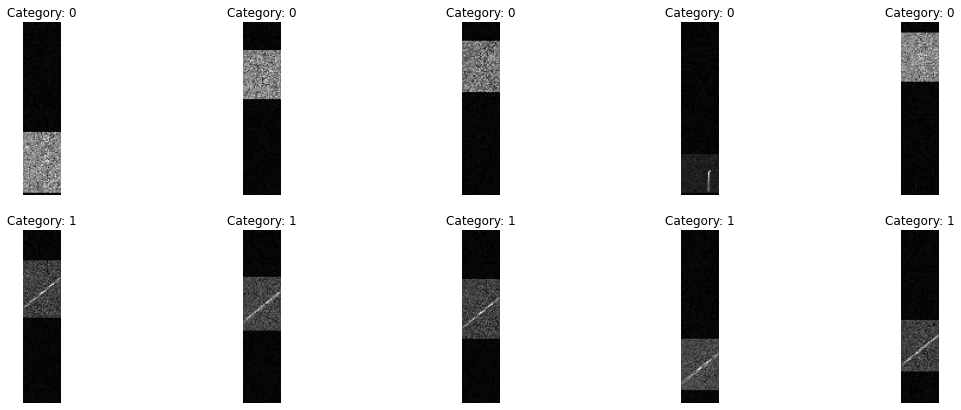

In [7]:
print_all_classes()

In [8]:
# 0
# max 4884 || (148.0, 33) 
# min 792 || (24.0, 33) 
#  1
# max 4587 || (139.0, 33) 
# min 792 || (24.0, 33) 

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(148,32),
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(148,32),
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 23322 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [10]:
training_dataset_size = train_generator.samples
testing_dataset_size = test_generator.samples
print(training_dataset_size,testing_dataset_size)

23322 600


In [11]:
len_gen_tr = len(train_generator)
len_gen_t = len(test_generator)

In [12]:
iter(train_generator)[0][0].shape

(256, 148, 32, 1)

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        if n <10:
            ax = plt.subplot(2, 5,n+1)
            plt.imshow(image_batch[n])
            if label_batch[n][1]:
                plt.title("1")
            else:
                plt.title("0")
            plt.axis("off")
        else:
            break

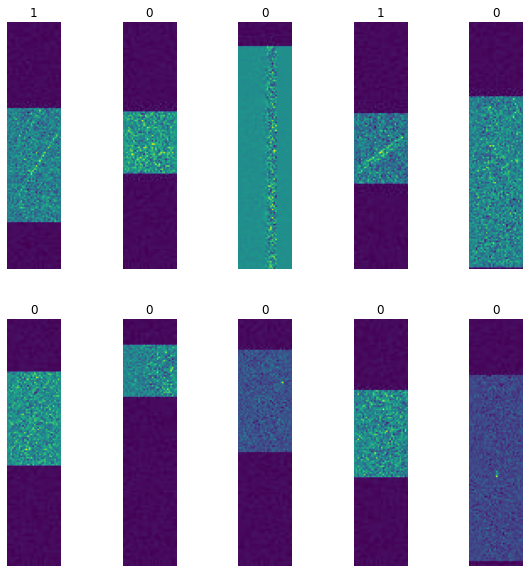

In [14]:
image_batch, label_batch = next(iter(train_generator))

show_batch(image_batch, label_batch)

In [15]:
print(image_batch.shape, label_batch.shape)

(256, 148, 32, 1) (256, 2)


# Построение модели

In [16]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [17]:
#tf.keras.backend.clear_session()

In [18]:
model = Sequential(name = "RNN")
model.add(Reshape(target_shape=(148,32),input_shape=(148,32,1)))
model.add(LSTM(128,input_shape = (148,32),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))

In [19]:
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 148, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 148, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 148, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0       

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_model = ModelCheckpoint('B:/STARS_05/model/stars_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_model = EarlyStopping(monitor='val_accuracy',
                          patience=20,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [21]:
model_history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_model, earlystop_model])

Epoch 1/200
91/91 [==============================] - 20s 147ms/step - loss: 0.5052 - accuracy: 0.8400 - val_loss: 0.9351 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to B:/SKILL_FACTORY/STARS_05/model\stars_model.h5
Epoch 2/200
91/91 [==============================] - 12s 135ms/step - loss: 0.4383 - accuracy: 0.8419 - val_loss: 0.9509 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/200
91/91 [==============================] - 13s 139ms/step - loss: 0.4339 - accuracy: 0.8415 - val_loss: 0.8042 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/200
91/91 [==============================] - 13s 137ms/step - loss: 0.3987 - accuracy: 0.8420 - val_loss: 0.6118 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/200
91/91 [==============================] - 12s 127ms/step - loss: 0.3664 - accuracy: 0.8410 - val_loss: 0.5422 - val_accuracy

91/91 [==============================] - 12s 128ms/step - loss: 0.1582 - accuracy: 0.9450 - val_loss: 0.1025 - val_accuracy: 0.9717

Epoch 00037: val_accuracy did not improve from 0.97333
Epoch 38/200
91/91 [==============================] - 12s 135ms/step - loss: 0.1565 - accuracy: 0.9459 - val_loss: 0.1098 - val_accuracy: 0.9667

Epoch 00038: val_accuracy did not improve from 0.97333
Epoch 39/200
91/91 [==============================] - 13s 138ms/step - loss: 0.1544 - accuracy: 0.9466 - val_loss: 0.0900 - val_accuracy: 0.9667

Epoch 00039: val_accuracy did not improve from 0.97333
Epoch 40/200
91/91 [==============================] - 12s 129ms/step - loss: 0.1503 - accuracy: 0.9471 - val_loss: 0.0956 - val_accuracy: 0.9700

Epoch 00040: val_accuracy did not improve from 0.97333
Epoch 41/200
91/91 [==============================] - 12s 129ms/step - loss: 0.1556 - accuracy: 0.9458 - val_loss: 0.1023 - val_accuracy: 0.9600

Epoch 00041: val_accuracy did not improve from 0.97333
Epoch 42

In [22]:
model.save('B:/STARS_05/model/stars_model_1.h5')